# UDE with integral regularization

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behavior
rng = StableRNG(1);

### 1. Define the ODE and sample one data set

In [2]:
function rhs!(du, u, p, t)
    du[1] = p*u[1] + 1
end

α0 = -1.0
u0 = [3.0]
tspan = (0.0, 10.0)

prob = ODEProblem(rhs!, u0, tspan, α0)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 0.1);

In [3]:
t = sol.t
X = Array(sol)
dist = Normal(0, 0.01)
noise = rand(rng, dist, length(X[begin:2:end]))
X_noisy = X[begin:2:end] .+ noise;

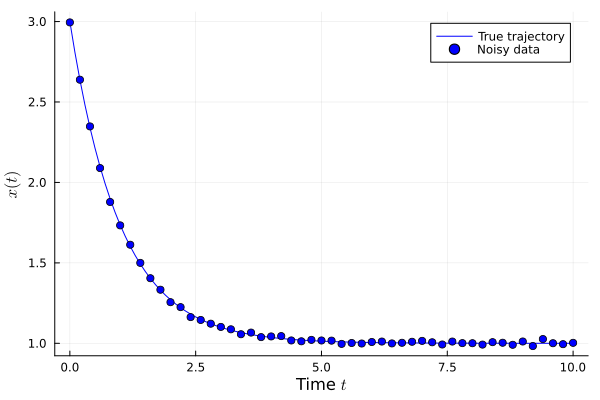

In [4]:
plot(t, X', xlabel = "Time \$t\$", ylabel = "\$x(t)\$", color = :blue, label = "True trajectory")
scatter!(t[begin:2:end], X_noisy, color = :blue, label = "Noisy data")

### 2. Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u, \alpha)+\text{NN}(u, \theta)$.

In [5]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))

# Multi-layer feed-forward neural network
model = Chain(Dense(1, 4, rbf), Dense(4, 4, rbf), Dense(4, 4, rbf), Dense(4, 1))

# Get initial parameters and state variables of the model
θ_init, st = Lux.setup(rng, model);

In [6]:
# Define the hybrid model
function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p.nn, st)[1]  
    du[1] = p.α*u[1] + nn[1]
end

α_init = -1.0
p_init = (nn = θ_init, α = α_init)
p_init = ComponentVector(p_init)
prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### 3. Set up the training

In [7]:
function predict(p, saveat = t[begin:2:end])   # p contains NN parameters θ and mechanistic parameter α of the ODE
    _prob = remake(prob_ude, p = p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = saveat,
                sensealg = QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

\$ \sum_i\int_0^T|\text{NN}_i(x(t),\theta)| dt $ 

\$ \approx\sum_{n=0}^{N-1}\sum_i(t_{n+1}-t_n)|\text{NN}_i(x(t_n),\theta)|$

In [8]:
function loss(x, p)   # x: optimized variable, p: parametrization of the objective
    if p.reg == nothing
        X̂ = predict(x)
        mean(abs2, X_noisy .- X̂)   
    elseif p.reg == "L2 θ"
        X̂ = predict(x)
        mean(abs2, X_noisy .- X̂) + p.ω * norm(x.nn)
    elseif p.reg == "Integral"
        X̂_fine = predict(x, t)
        X̂ = X̂_fine[:, begin:2:end]
        mean(abs2, X_noisy .- X̂) + p.ω * norm(0.1*Lux.apply(model, X̂_fine[:, begin:end-1], x.nn, st)[1], 1)
    end
end;

### 4. Method to train the UDE using different regularization techniques

In [9]:
function train_ude(reg, ω, adam_epochs = 5000, bfgs_epochs = 5000, print_loss = false)
    # Set up histories for loss and parameter estimates
    losses = Float64[]
    α_hist = Float64[]
    function callback(p, l)
        push!(losses, l)
        push!(α_hist, p.α)
        if print_loss
            n_iter = length(losses)
            if n_iter % 250 == 0   
                println("Loss after $(n_iter) iterations: $(losses[end])")
            end
        end
        return false
    end
    
    # Set up optimization problem
    adtype = AutoZygote()
    optf = OptimizationFunction(loss, adtype)
    optprob = OptimizationProblem(optf, p_init, (reg = reg, ω = ω))
    
    # Hybrid training procedure combining Adam and BFGS
    if print_loss
        println("Using Adam:")
    end
    res1 = solve(optprob, ADAM(), callback = callback, maxiters = adam_epochs)
    optprob2 = OptimizationProblem(optf, res1.u, (reg = reg, ω = ω))
    if print_loss
        println("Using BFGS:")
    end
    res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = bfgs_epochs)
    p_trained = res2.u;
    
    return [reg, ω, adam_epochs, losses, α_hist, p_trained]    
end;

### 5. Method to visualize the results

In [10]:
function visualize(result)  
    # Unpack result
    reg, ω, adam_epochs, losses, α_hist, p_trained = result    
    
    # Print type of regularization and estimated mechanistic parameter
    println("Regularization: $(reg), ω: $(ω)")
    println("Estimate of α: $(p_trained.α)")
    
    # Convergence plot
    p1 = plot(1:adam_epochs, losses[1:adam_epochs], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM",
              color=:blue)
    plot!(adam_epochs+1:length(losses), losses[adam_epochs+1:end], yaxis=:log10, label="BFGS", color=:red)
    
    # Parameter estimate plot
    p2 = plot(1:adam_epochs, α_hist[1:adam_epochs], xlabel="Iterations", ylabel="Estimated α", label="ADAM", 
              color=:blue)
    plot!(adam_epochs+1:length(α_hist), α_hist[adam_epochs+1:end], label="BFGS", color=:red)
    plot!(1:length(α_hist), α0*ones(length(α_hist)), linestyle = :dash, label="Ground truth", color=:grey10)
    
    # Data fit
    X̂ = predict(p_trained, t)
    p3 = plot(t, X', xlabel = "Time \$t\$", ylabel = "\$x(t)\$", color = :blue, label = "True trajectory")
    plot!(t, X̂', color = :blue, linestyle = :dash, label = "UDE approximation")
    scatter!(t[begin:2:end], X_noisy, color = :blue, label = "Noisy data")
        
    # True residual dynamics (i.e. interactions of predictors) along the true trajectory
    dynamics_true = ones(length(t))
    # Neural network guess along the true trajectory
    dynamics_nn = Lux.apply(model, X, p_trained.nn, st)[1]
    # Compare true and learned residual dynamics
    p4 = plot(t, dynamics_true, xlabel = "Time \$t\$", ylabel = "Residual dynamics", color = :blue, label = "True")
    plot!(t, dynamics_nn', color = :blue, linestyle = :dash, label = "NN(x)")
       
    # Combined plot
    plot(p1, p2, p3, p4, size=(800,600), layout=(2,2))
end;

### 6. Train UDEs and compare results

Regularization: nothing, ω: nothing
Estimate of α: -5.512229335866401


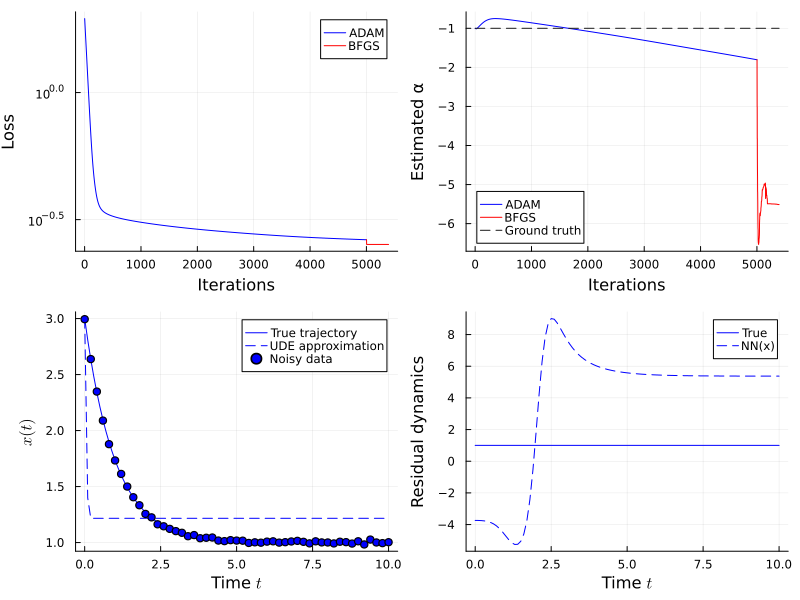

In [11]:
visualize(train_ude(nothing, nothing))

Regularization: Integral, ω: 0.01
Estimate of α: 1.3142099138918597e-5


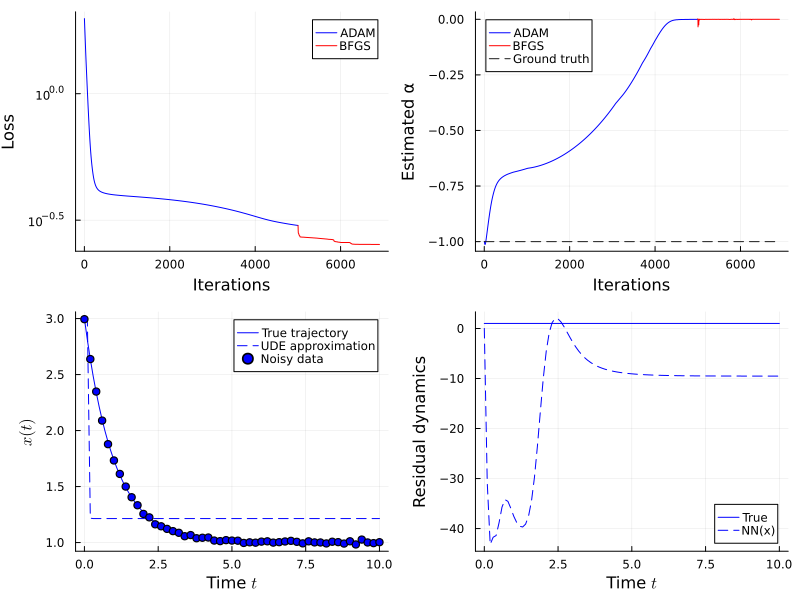

In [12]:
visualize(train_ude("Integral", 0.01))

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606


Regularization: Integral, ω: 0.005
Estimate of α: -1.0222746647832227e-6


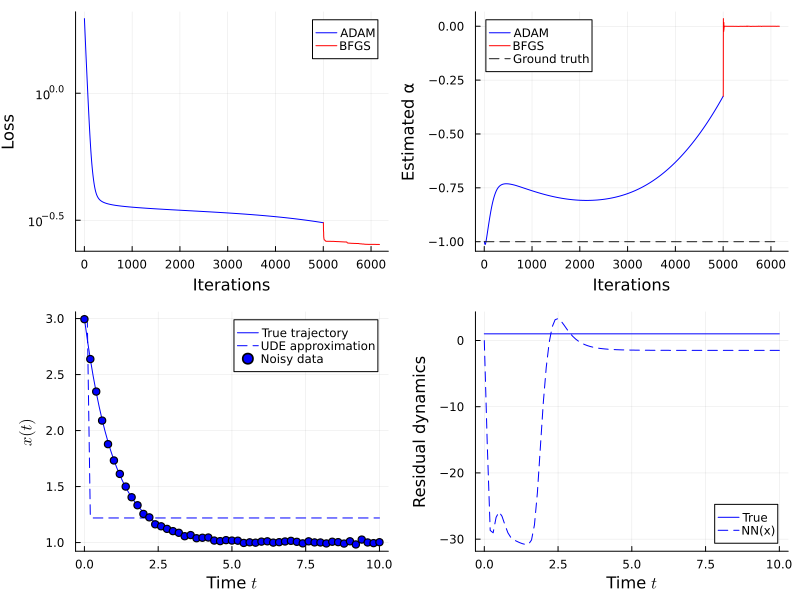

In [11]:
visualize(train_ude("Integral", 0.005))

In [ ]:
visualize(train_ude("Integral", 0.001))

In [ ]:
visualize(train_ude("Integral", 0.0005))

In [ ]:
visualize(train_ude("Integral", 0.0001))

In [ ]:
visualize(train_ude("L2 θ", 0.01))

In [ ]:
visualize(train_ude("L2 θ", 0.005))

In [ ]:
visualize(train_ude("L2 θ", 0.001))

In [ ]:
visualize(train_ude("L2 θ", 0.0005))

In [ ]:
visualize(train_ude("L2 θ", 0.0001))

### 7. Compare with theoretical considerations for the integral regularization

In [12]:
using Optim, QuadGK

integrand(t, α) = abs(1 - (α + 1) * (2 * exp(-t) + 1))
loss_int(α) = quadgk(t -> integrand(t, α), 0.0, 10.0)[1]
optimize(loss_int, -20.0, 20.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-20.000000, 20.000000]
 * Minimizer: -3.415557e-02
 * Minimum: 1.929370e+00
 * Iterations: 33
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 34